# Assignment_1

### Student Name - Nitesh Gupta
### Student ID - R00195231

In [90]:
import gensim
import pandas as pd
import random
import re
import nltk
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

###  Files_Path  

Dataset is downloaded from link given in assignment and it should be present in root dirtectory of project. I haven't included due to its large size. 

In [93]:
class DataStoragePath:
    """Class for data storage paths"""
    TRAIN_DATA_PATH = "MADAR-Corpus-26-train.tsv"
    TEST_DATA_PATH = "MADAR-Corpus-26-dev.tsv" 
    FULL_GRAM_CBOW_100_MDL_FILE='full_grams_cbow_100_twitter.mdl'

#### Train Word2Vec model with gensim on the dataset

In [94]:
model = gensim.models.Word2Vec.load(DataStoragePath.FULL_GRAM_CBOW_100_MDL_FILE)
print("We've",len(model.wv.index2word),"vocabularies")

We've 1476715 vocabularies


##### Retrieve the weights from the model. This is used for initializing the weights in a Keras Embedding layer later

In [95]:
w2v_weights = model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

In [96]:
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 1476715 - Embedding Dim: 100


### Train Data and Test Data Collection 

In [97]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

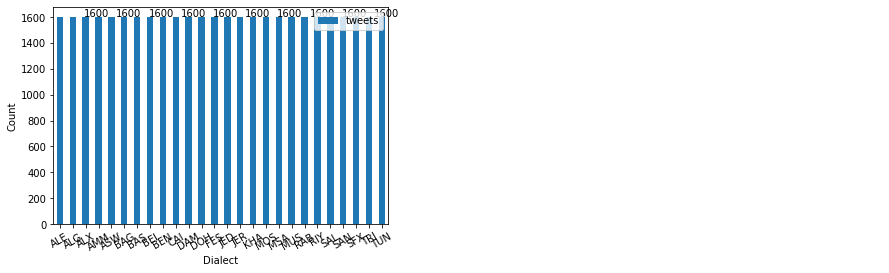

In [98]:
train_data = pd.read_csv(DataStoragePath.TRAIN_DATA_PATH, sep='\t')
train_data.columns = ['tweets', 'dialect']

axes = train_data.groupby("dialect").count().plot.bar()
axes.set_xlabel('Dialect')
axes.set_ylabel('Count')
plt.sca(axes)
plt.xticks(rotation=30)
for p in axes.patches:
    axes.annotate(str(p.get_height()), (p.get_x() * 2.5, p.get_height() * 1.005))
print()

In [99]:
print(f"Shape: {train_data.shape}")

train_data.head()

Shape: (41599, 2)


,tweets,dialect
0,لم اسمع بهذا العنوان من قبل بالقرب من هنا .,MSA
1,استمر في السير في هذا الطريق حتى تجد صيدلية .,MSA
2,كم تكلفة الإفطار ؟,MSA
3,كيف أستطيع مساعدتك ؟,MSA
4,اتجه يسارا عند الناصية الثالثة .,MSA


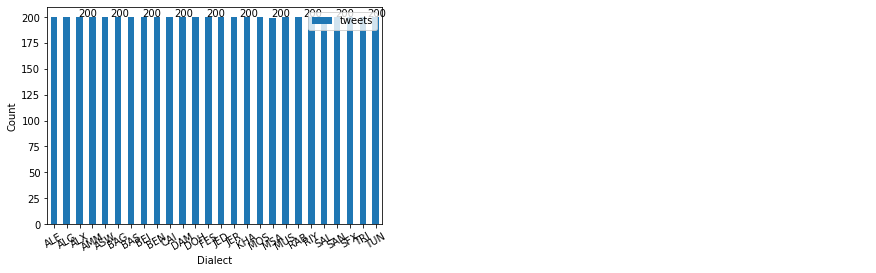

In [100]:
test_data = pd.read_csv(DataStoragePath.TEST_DATA_PATH, sep='\t')
test_data.columns = ['tweets', 'dialect']

axes = test_data.groupby("dialect").count().plot.bar()
axes.set_xlabel('Dialect')
axes.set_ylabel('Count')
plt.sca(axes)
plt.xticks(rotation=30)
for p in axes.patches:
    axes.annotate(str(p.get_height()), (p.get_x() * 2.5, p.get_height() * 1.005))
print()

In [101]:
print(f"Shape: {test_data.shape}")

test_data.head()

Shape: (5199, 2)


,tweets,dialect
0,"هذا القطار يتوقف في لاك فورست , أليس كذلك ؟",MSA
1,"هذا الكارت , حسناً ؟",MSA
2,لم يخرج من الماكينة شيء .,MSA
3,عندك أية شيء يمكن أن أتعاطه للطفح الجلدي ؟,MSA
4,أكيدا التي تتحدث معك ، أنا عندي حجز مائدة في ت...,MSA


#### Text Preprocessing Method

* **Minimum term length**: Exclude terms of length < 2: Done automatically by scikit-learn's vectorizer
* **Case conversion**: Converting all terms to lowercase. Done automatically by scikit-learn's vectorizer. But I performed it due     to caution.
* **Word Stemming**: Process to reduce a term to its canonical form.
* **Stop-word filtering**: Remove terms that appear on a pre-defined filter list of terms that are highly frequent and don not       convey useful information.
* **Low frequency filtering**: Remove terms that appear in very few documents.
* **Term weighting**: Giving heigher weights to more "important" terms. Used *TF-IDF* approach. Giving more weight when a term         appears multiple times in a single document and penalizsing common terms that appear in almost every document.

In [102]:
import re
def preprocessing(data, infrequent_words_removal_count=10):
    # Making all letters lowercase
    data["tweets"] = data["tweets"].apply(lambda x: " ".join(x.lower() for x in x.split()))

    # Removing Punctuation, Symbols
    data['tweets'] = data['tweets'].str.replace('[^\w\s]', ' ')

    # Code to find the top 10 rarest words appearing in the data
    freq = pd.Series(' '.join(data["tweets"]).split()).value_counts()[-infrequent_words_removal_count:]

    # Removing all those rarely appearing words from the data
    freq = list(freq.index)
    data["tweets"] = data["tweets"].apply(
        lambda line: " ".join(line for line in line.split() if line not in freq))

    # Removing repeating words 
    def de_repeat(text):
        pattern = re.compile(r"(.)\1{2,}")
        return pattern.sub("r\1\1", text)

    data["tweets"] = data["tweets"].apply(lambda line: " ".join(de_repeat(line) for line in line.split()))
    return data

#### Train Data Preprocessing 

In [103]:
train_data = preprocessing(train_data,10000)

#### Test Preprocessing

In [104]:
test_data = preprocessing(test_data)

######  Removing Stop Words using NLTK 

In [105]:
from nltk.corpus import stopwords
stemmer = nltk.stem.isri.ISRIStemmer()
stemmed_stop_words = [stemmer.stem(words) for words in stopwords.words()]
print("Sample stopwords:", stemmed_stop_words[0:10])

Sample stopwords: ['اذ', 'اذا', 'اذم', 'اذن', 'اف', 'اقل', 'كثر', 'الا', 'الا', 'التي']


In [106]:
STOPWORDS = stemmed_stop_words
def clean_text(text):
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [107]:
train_data['tweets'] = train_data['tweets'].apply(clean_text)

In [108]:
test_data['tweets'] = test_data['tweets'].apply(clean_text)

#### Tokenization 

Tokens are created by keras.preprocessing.tokenizer. It  is filtered unneccessary data and stored word index. 

In [109]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_data['tweets'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 17251 unique tokens.


### Conversion text to sequence 

Tweets and dialect are converted into numeric sequences by pad_sequence and get dummies method 

In [110]:
X_train = tokenizer.texts_to_sequences(train_data['tweets'].values)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train_data tensor:', X_train.shape)

Shape of train_data tensor: (41599, 250)


In [111]:
Y_train = pd.get_dummies(train_data['dialect']).values
print('Shape of train_label tensor:', Y_train.shape)

Shape of train_label tensor: (41599, 26)


In [112]:
X_test = tokenizer.texts_to_sequences(test_data['tweets'].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test_data tensor:', X_test.shape)

Shape of test_data tensor: (5199, 250)


In [113]:
Y_test = pd.get_dummies(test_data['dialect']).values
print('Shape of test_label tensor:', Y_test.shape)

Shape of test_label tensor: (5199, 26)


In [114]:
print("Train Shapes - X: {} - Y: {}".format(X_train.shape, Y_train.shape))
print("Test Shapes - X: {} - Y: {}".format(X_test.shape, Y_test.shape))

Train Shapes - X: (41599, 250) - Y: (41599, 26)
Test Shapes - X: (5199, 250) - Y: (5199, 26)


### Sequential Model with LSTM Architecture 

In [60]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=embedding_size,weights=[w2v_weights], input_length=X_train.shape[1]))

model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(26, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=5, batch_size=64,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
585/585 [==============================] - 1629s 3s/step - loss: 3.1079 - accuracy: 0.0908 - val_loss: 8.0492 - val_accuracy: 0.0000e+00
Epoch 2/5
585/585 [==============================] - 1788s 3s/step - loss: 2.7876 - accuracy: 0.1837 - val_loss: 10.3859 - val_accuracy: 0.0000e+00
Epoch 3/5
585/585 [==============================] - 1620s 3s/step - loss: 2.4583 - accuracy: 0.2631 - val_loss: 11.4440 - val_accuracy: 0.0000e+00
Epoch 4/5
585/585 [==============================] - 1624s 3s/step - loss: 2.2697 - accuracy: 0.3102 - val_loss: 12.1731 - val_accuracy: 0.0000e+00


In [64]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

163/163 [==============================] - 6s 34ms/step - loss: 3.0121 - accuracy: 0.3412
Test set
  Loss: 3.012
  Accuracy: 0.341


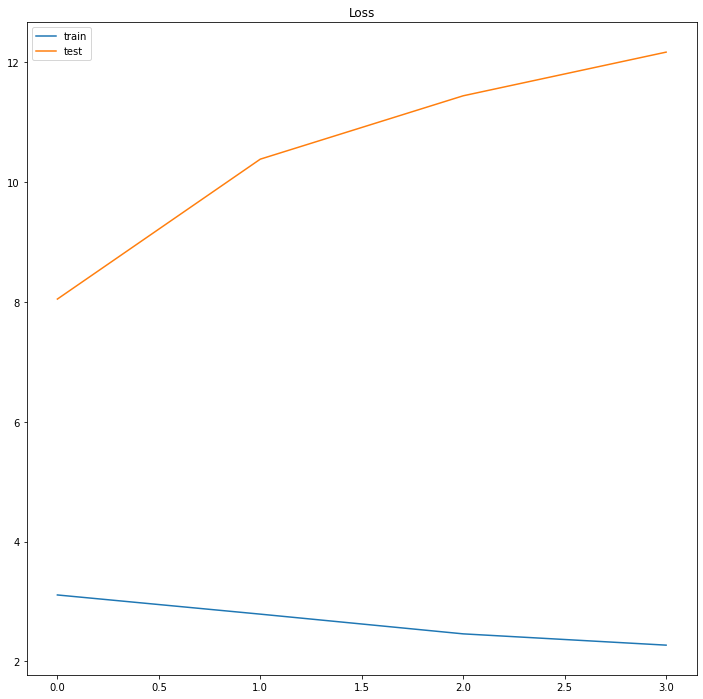

In [72]:
plt.figure(figsize=(12, 12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

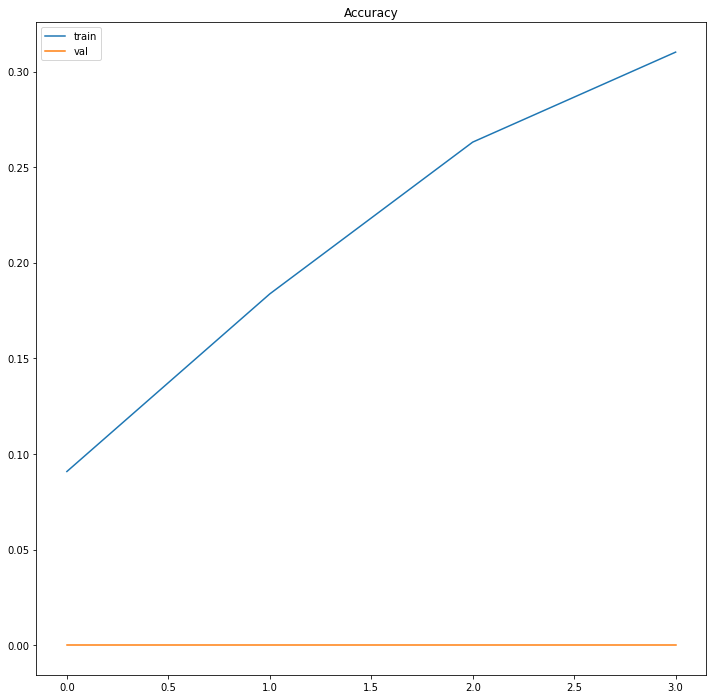

In [69]:
plt.figure(figsize=(12, 12))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Conclusion 

The plots suggest that the model has a little underfitting problem, different set of hyper tuned values might be helpful. The Pretrained model consumes heavy computational time but can be useful to produce prediction accurately . This part assignment taught us about LSTM architecture

### Reference


https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17